# Assignment 2

Download your data and m a 12-panel plot of the climatology (1 panel for each month). Make the plot look publication quality with titles, units, labels, good colorbar, continents, etc.

If your data is not at a time frequency that allows monthly climatology, either choose individual times or a different aggregation (seasonal? Year?)

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

In [11]:
model_path = '/home/lortizur/clim680/project_data/'
model_file = 'era5_monthlymax_1985-2014.nc'
#openn file
ds_model = xr.open_dataset(model_path + model_file)
ds_model

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 360, lat: 721, lon: 1440)
Coordinates:
    realization  int64 8B ...
  * lat          (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon          (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time         (time) datetime64[ns] 3kB 1985-01-31 1985-02-28 ... 2014-12-31
Data variables:
    t2m          (time, lat, lon) float32 1GB ...
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-09-02T10:15 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

Text(0.5, 1.0, 'ERA5 -180-180')

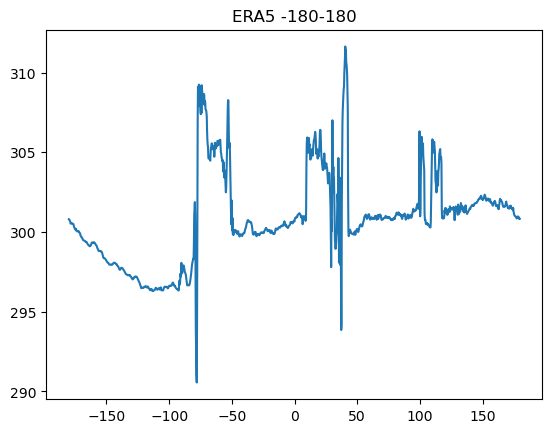

In [12]:
t2m_check = ds_model['t2m'].sel(lat=0,
                                time=ds_model['time'][0],
                                method='nearest')
plt.plot(ds_model['lon'],t2m_check)
plt.title('ERA5 -180-180')

In [13]:
#Change the longitudes from -180-180 to 0-360
#values will start at 180, because our old first data set, -180, turns into 180
    #order gets a little messed up
new_lons = ((ds_model['lon'] + 360) % 360)
new_lons

<xarray.DataArray 'lon' (lon: 1440)> Size: 12kB
array([180.  , 180.25, 180.5 , ..., 179.25, 179.5 , 179.75])
Coordinates:
    realization  int64 8B ...
  * lon          (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

In [14]:
#add new_lons to dataset
ds_model2 = ds_model.assign_coords(lon=new_lons)
ds_model2['lon']

<xarray.DataArray 'lon' (lon: 1440)> Size: 12kB
array([180.  , 180.25, 180.5 , ..., 179.25, 179.5 , 179.75])
Coordinates:
    realization  int64 8B ...
  * lon          (lon) float64 12kB 180.0 180.2 180.5 ... 179.2 179.5 179.8

In [15]:
#telling it to sort and reorder everything a long the newly created lons we assigned
#default is ascending order --> keep, we want lons to go from 0-360
ds_model2 = ds_model2.sortby(ds_model2['lon'])
ds_model2

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 360, lat: 721, lon: 1440)
Coordinates:
    realization  int64 8B ...
  * lat          (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * time         (time) datetime64[ns] 3kB 1985-01-31 1985-02-28 ... 2014-12-31
  * lon          (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    t2m          (time, lat, lon) float32 1GB ...
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-09-02T10:15 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

Text(0.5, 1.0, 'ERA5 0-360')

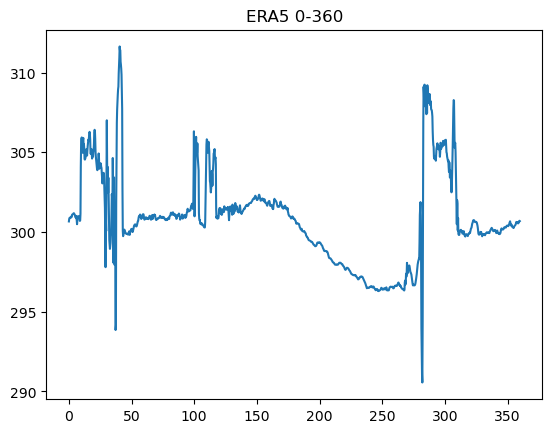

In [16]:
#replotting with our new dataset and new coordinates
#should expect it to be a little bit shifted
t2m_check2 = ds_model2['t2m'].sel(lat=0,
                                    time=ds_model2['time'][0],
                                    method='nearest')
plt.plot(ds_model2['lon'],t2m_check2)
plt.title('ERA5 0-360')

In [17]:
#group months from every year together to get the climatology of each month
ds_model2_monthly = ds_model2.groupby('time.month').mean()
ds_model2_monthly

<xarray.Dataset> Size: 50MB
Dimensions:      (month: 12, lat: 721, lon: 1440)
Coordinates:
    realization  int64 8B 0
  * lat          (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon          (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m          (month, lat, lon) float32 50MB 251.3 251.3 ... 262.1 262.1
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-09-02T10:15 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

Text(0.55, 0.95, 'Maximum Temperature (K) from 1985-2014')

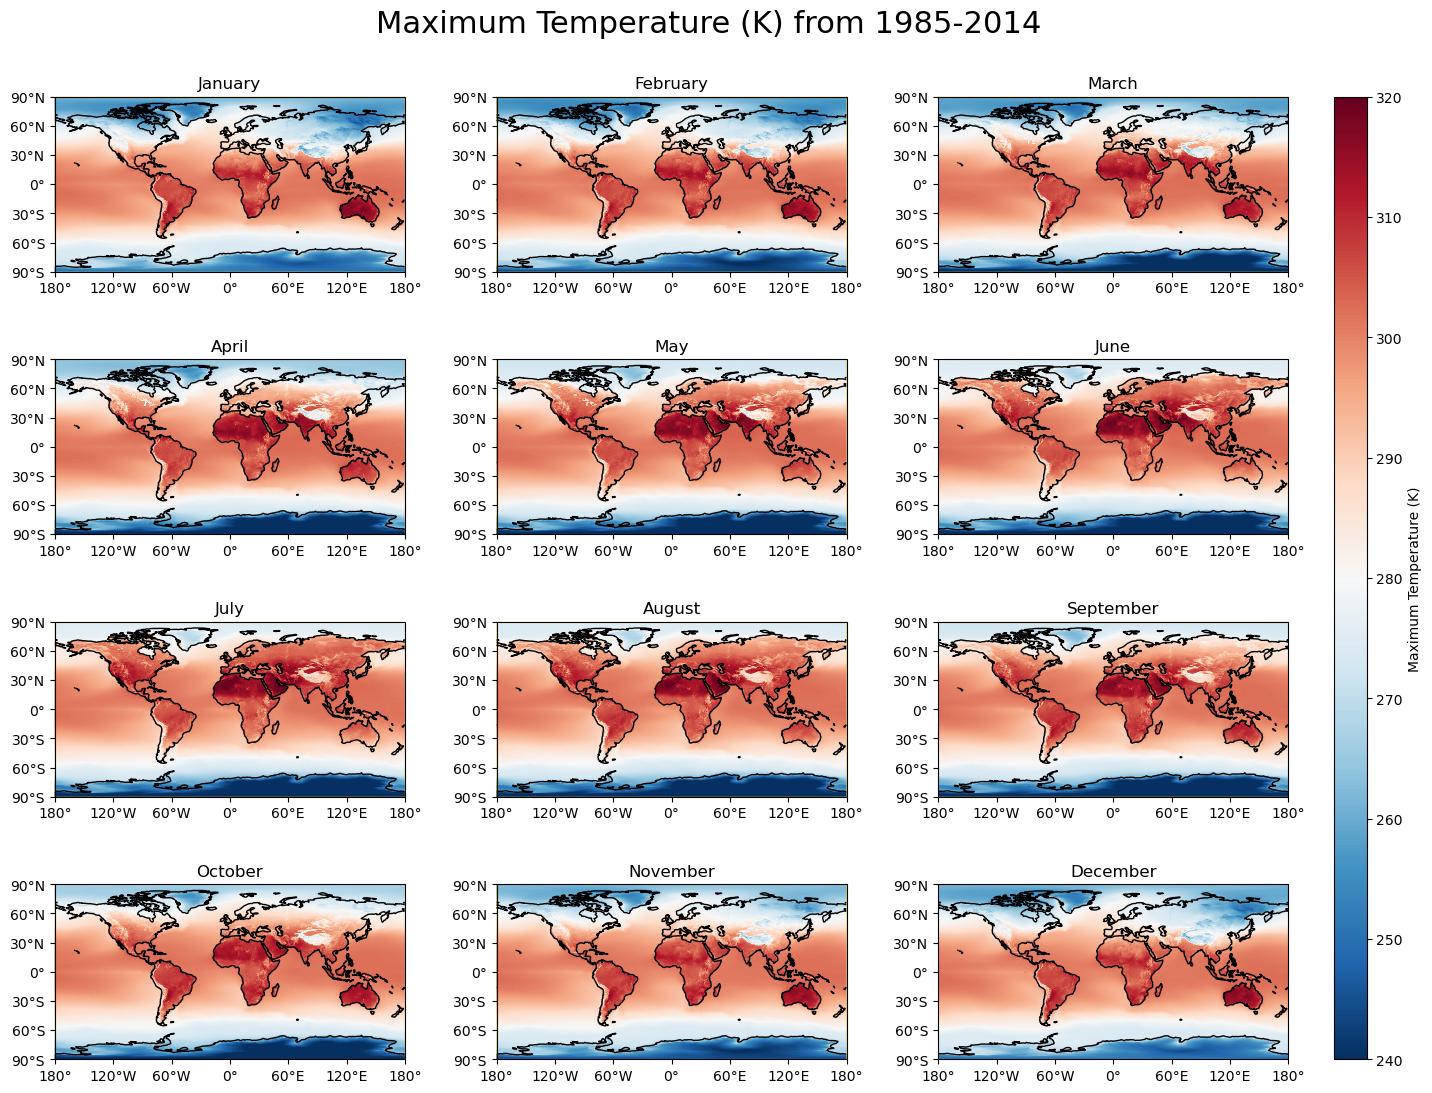

In [27]:
#labels
months_str = 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
clevs=np.arange(-5,36,5)

# define the figure and each axis for 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4,ncols=3, figsize=(25,12.5), subplot_kw={'projection': ccrs.PlateCarree()})

#ax = plt.axes(projection=ccrs.PlateCarree())

# axs is a 2D array of 'GeoAxes,' we need to flatten it into a 1D array (4 rows)
axs=axs.flatten()

#loop over every month and plot
for i,month in enumerate(ds_model2_monthly['month']):
    #select the month
    data = ds_model2_monthly['t2m'].sel(month=month)
    
    #add the cyclic point
    data,lons = add_cyclic_point(data,coord=ds_model2_monthly['lon'])
    
    #contour plot
    cs=axs[i].contourf(lons,ds_model2_monthly['lat'],data,clevs,
                       transform = ccrs.PlateCarree(),extend='both')
     
    #longitude labels
    axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
             
    #latitude labels
    axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
             
    #Title each subplot with the name of the month
    axs[i].set_title(months_str[i])
             
    #draw the coastlines for each subplot
    axs[i].coastlines()
    
    #colormap
    pcm = axs[i].pcolormesh(lons,ds_model2_monthly['lat'],data,vmin=240,vmax=320,cmap='RdBu_r')

#Adjust the location of subplots
fig.subplots_adjust(left=0.27, right=0.8, wspace=0.00009, hspace=0.5)

#add a colorbar axis to the right of the graph [left, botton, width, height]
cbar_ax = fig.add_axes([0.8, 0.11, 0.013, 0.77])

#convert colorbar ticks from Celsius to Kelvin
cbar = fig.colorbar(pcm,cax=cbar_ax,orientation='vertical',label='Maximum Temperature (K)')

#Add a big title at the top
plt.suptitle('Maximum Temperature (K) from 1985-2014', x=0.55, y=0.95, fontsize=22)

In [17]:
vmax = np.max(data)
vmin = np.min(data)
print(vmin, vmax)

244.33382 318.8363


## Improvements

I would improve my figure by masking out the sea and increasing the resolution. 